In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats

df = pd.read_csv('..\data\data.csv') 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Best test set accuracy: 0.8048780487804879
Achieved with hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Training Accuracy: 0.7841140529531568
Testing Accuracy: 0.8048780487804879
Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        38
           1       0.83      0.91      0.87        85

    accuracy                           0.80       123
   macro avg       0.78      0.74      0.76       123
weighted avg       0.80      0.80      0.80       123



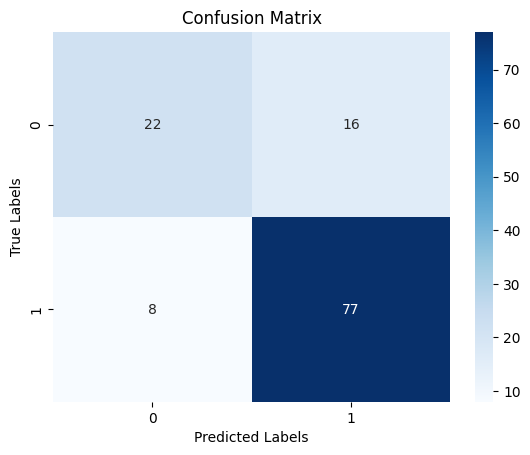

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import cleaning as cl
import features_engineering as fe
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# #Define the target

X= df.drop('Loan_Status',axis=1)
y= df['Loan_Status']
y= y.replace({'N': 0, 'Y': 1})

# #  Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['LoanAmount', 'Loan_Amount_Term', 'total_income']),  # Apply StandardScaler to numerical columns
        ('cat', OneHotEncoder(), ['Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'family_size'])  # Apply OneHotEncoder to categorical columns
    ])
cleaning_object = FunctionTransformer(cl.missing_value)

features_engineering_object = FunctionTransformer(fe.features_eng)



pipeline = Pipeline(steps=[
    ('df_clean', cleaning_object),
    ('df_eng', features_engineering_object),
    ('df_trans', preprocessor),
    ('classifier', XGBClassifier())
])


# # Find the best hyperparameters using GridSearchCV on the train set
param_grid = {
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__max_depth': [3, 5, 7],
    'classifier__n_estimators': [100, 200, 500]
}

grid = GridSearchCV(pipeline,param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_hyperparams = grid.best_params_
best_acc = grid.score(X_test, y_test)
print(f'Best test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperparams}')


# # Calculate the training accuracy
train_accuracy = best_model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# # Calculate the testing accuracy
test_accuracy = best_model.score(X_test, y_test)
print("Testing Accuracy:", test_accuracy)


# Make predictions on the testing data
y_pred = best_model.predict(X_test)
#Classification Report
print("Classification Report (Default Threshold):")
print(classification_report(y_test, y_pred))
# Plot the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()